# Weekly Patterns in Energy and Gas Usage Report

This notebook analyzes weekly patterns in electricity and gas usage and tests for significant differences across days using ANOVA.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from home_messages_db import HomeMessagesDB
from scipy import stats

# Connect to database
db = HomeMessagesDB('sqlite:///smarthome.db')

# Fetch data
electricity_data = db.query_electricity()
gas_data = db.query_gas()

# Convert to DataFrames and calculate differences
electricity_df = pd.DataFrame([(e.epoch, e.t1_kwh, e.t2_kwh) for e in electricity_data],
                             columns=['epoch', 't1_kwh', 't2_kwh']).sort_values('epoch')
gas_df = pd.DataFrame([(g.epoch, g.gas_m3) for g in gas_data],
                     columns=['epoch', 'gas_m3']).sort_values('epoch')

electricity_df['t1_kwh_diff'] = electricity_df['t1_kwh'].diff().fillna(0)
electricity_df['t2_kwh_diff'] = electricity_df['t2_kwh'].diff().fillna(0)
gas_df['gas_m3_diff'] = gas_df['gas_m3'].diff().fillna(0)

# Filter out negative differences
electricity_df = electricity_df[(electricity_df['t1_kwh_diff'] >= 0) & (electricity_df['t2_kwh_diff'] >= 0)]
gas_df = gas_df[gas_df['gas_m3_diff'] >= 0]

# Convert epoch to datetime and extract day of week
electricity_df['datetime'] = pd.to_datetime(electricity_df['epoch'], unit='s', utc=True)
electricity_df['day_of_week'] = electricity_df['datetime'].dt.day_name()
gas_df['datetime'] = pd.to_datetime(gas_df['epoch'], unit='s', utc=True)
gas_df['day_of_week'] = gas_df['datetime'].dt.day_name()

# Aggregate by day of week
weekly_electricity = electricity_df.groupby('day_of_week').agg({'t1_kwh_diff': 'mean', 't2_kwh_diff': 'mean'}).reset_index()
weekly_gas = gas_df.groupby('day_of_week').agg({'gas_m3_diff': 'mean'}).reset_index()

# Order days of week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_electricity['day_of_week'] = pd.Categorical(weekly_electricity['day_of_week'], categories=days_order, ordered=True)
weekly_gas['day_of_week'] = pd.Categorical(weekly_gas['day_of_week'], categories=days_order, ordered=True)
weekly_electricity = weekly_electricity.sort_values('day_of_week')
weekly_gas = weekly_gas.sort_values('day_of_week')

# Close database connection
db.close()

# Display the first few rows
weekly_electricity.head(), weekly_gas.head()

(  day_of_week  t1_kwh_diff  t2_kwh_diff
 1      Monday     0.034375     0.054120
 5     Tuesday     0.029379     0.057002
 6   Wednesday     0.031554     0.061312
 4    Thursday     0.032527     0.054932
 0      Friday     0.031745     0.061905,
   day_of_week  gas_m3_diff
 1      Monday     0.030637
 5     Tuesday     0.029048
 6   Wednesday     0.030957
 4    Thursday     0.030014
 0      Friday     0.030543)

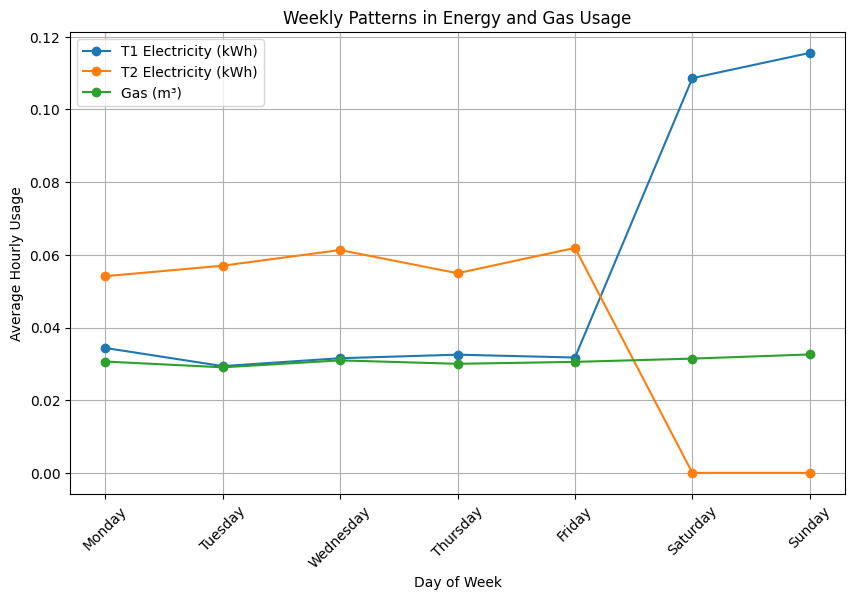

In [2]:
# Plot weekly patterns
plt.figure(figsize=(10, 6))
plt.plot(weekly_electricity['day_of_week'], weekly_electricity['t1_kwh_diff'], label='T1 Electricity (kWh)', marker='o')
plt.plot(weekly_electricity['day_of_week'], weekly_electricity['t2_kwh_diff'], label='T2 Electricity (kWh)', marker='o')
plt.plot(weekly_gas['day_of_week'], weekly_gas['gas_m3_diff'], label='Gas (m³)', marker='o')
plt.xlabel('Day of Week')
plt.ylabel('Average Hourly Usage')
plt.title('Weekly Patterns in Energy and Gas Usage')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Save the plot
plt.savefig('weekly_usage_patterns.png')
plt.show()

In [3]:
# Perform ANOVA test for T1 electricity
t1_data_by_day = [electricity_df[electricity_df['day_of_week'] == day]['t1_kwh_diff'].dropna().values for day in days_order]
f_statistic, p_value = stats.f_oneway(*t1_data_by_day)
print(f'ANOVA Test for T1 Electricity: F-statistic = {f_statistic:.2f}, p-value = {p_value:.4f}')

# Interpretation
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: There are significant differences in T1 electricity usage across days.')
else:
    print('Fail to reject the null hypothesis: No significant differences in T1 electricity usage across days.')

ANOVA Test for T1 Electricity: F-statistic = 2687.07, p-value = 0.0000
Reject the null hypothesis: There are significant differences in T1 electricity usage across days.


## Analysis
- **Weekly Patterns**:
  - The plot shows average hourly usage by day of week. Look for higher usage on weekends (Saturday/Sunday) or weekdays (e.g., Monday-Friday).
- **Statistical Component (ANOVA)**:
  - The p-value indicates whether there are statistically significant differences in usage across days.
  - A low p-value (< 0.05) suggests weekly patterns exist.